In [7]:
!pip install pmdarima pandas numpy matplotlib seaborn statsmodels scikit-learn lightgbm

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

In [9]:
train_df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv', parse_dates=['date'])
test_df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv', parse_dates=['date'])
stores_df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/stores.csv')
oil_df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/oil.csv', parse_dates=['date'])
holidays = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv', parse_dates=['date'])
transactions = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/transactions.csv', parse_dates=['date'])

# Convert sales column to numeric and handle non-numeric values
train_df['sales'] = pd.to_numeric(train_df['sales'], errors='coerce')
# Check for non-numeric values before imputation
non_numeric = train_df[train_df['sales'].isna()]
if not non_numeric.empty:
    print("Non-numeric sales values found:", non_numeric[['date', 'sales']].head())
# Fill NaN with forward fill to preserve time series continuity
train_df['sales'] = train_df['sales'].fillna(method='ffill')
print(f"Train sales dtype after conversion: {train_df['sales'].dtype}")
print(train_df.info())
print(train_df.describe())
print(train_df['store_nbr'].nunique(), "Stores")
print(train_df['family'].nunique(), "product family")

Train sales dtype after conversion: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB
None
                 id                           date     store_nbr  \
count  3.000888e+06                        3000888  3.000888e+06   
mean   1.500444e+06  2015-04-24 08:27:04.703087872  2.750000e+01   
min    0.000000e+00            2013-01-01 00:00:00  1.000000e+00   
25%    7.502218e+05            2014-02-26 18:00:00  1.400000e+01   
50%    1.500444e+06            2015-04-24 12:00:00  2.750000e+01   
75%    2.250665e+06            2016-06-19 06:00:00  4.100000e+01   
max    3.000887e

Sample sales dtype: float64


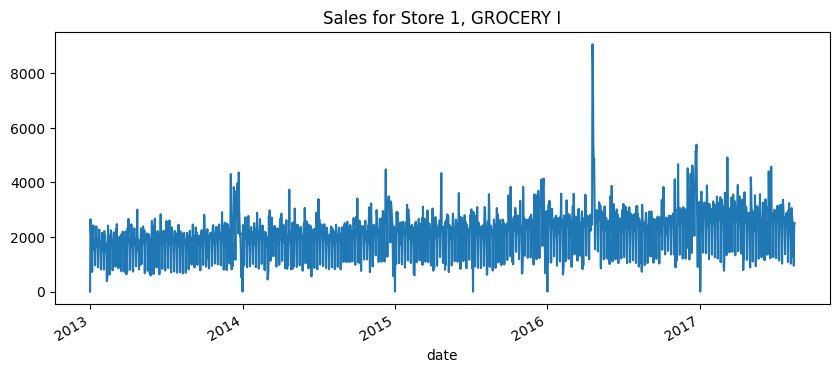

In [10]:
sample = train_df[(train_df['store_nbr'] == 1) & (train_df['family'] == 'GROCERY I')]
sample = sample.set_index('date')[['sales', 'onpromotion']]
print(f"Sample sales dtype: {sample['sales'].dtype}")
sample['sales'].plot(figsize=(10,4), title="Sales for Store 1, GROCERY I")
plt.show()

In [34]:
sales = sample['sales'].copy()
print(f"Sales dtype in Cell 5: {sales.dtype}")
if sales.isna().any():
    print(f"NaN values in sales: {sales.isna().sum()}")
    sales = sales.fillna(method='ffill')  # Forward fill NaN
if (sales < 0).any():
    print(f"Negative sales values found: {(sales < 0).sum()}")
    sales = sales.clip(lower=0)  # Ensure non-negative
# Check for sufficient data
if len(sales) < 100:
    print("Warning: Insufficient data points in sales")
train_end = pd.to_datetime('2017-07-31')
train = sales.loc[:train_end]
val = sales.loc[train_end + pd.Timedelta(days=1):]
val_length = len(val)
print(f"Train length: {len(train)}, Val length: {val_length}")
print(f"NaN in train: {train.isna().sum()}, NaN in val: {val.isna().sum()}")
# Verify index alignment
if val.empty or not val.index.equals(pd.date_range(start=val.index[0], periods=val_length, freq='D')):
    print("Warning: Validation set is empty or has irregular index")

Sales dtype in Cell 5: float64
Train length: 1669, Val length: 15
NaN in train: 0, NaN in val: 0


In [35]:
def test_stationarity(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    for key, value in result[4].items():
        print('Critical Values:')
        print(f'   {key}, {value}')

print("Stationarity test on train sales:")
test_stationarity(train)

Stationarity test on train sales:
ADF Statistic: -4.075306
p-value: 0.001064
Critical Values:
   1%, -3.4343339050195465
Critical Values:
   5%, -2.8632996655963554
Critical Values:
   10%, -2.567706805740553


In [36]:
sales_diff = train.diff().dropna()
print("Stationarity test on differenced sales:")
test_stationarity(sales_diff)

Stationarity test on differenced sales:
ADF Statistic: -12.153403
p-value: 0.000000
Critical Values:
   1%, -3.4343387651403106
Critical Values:
   5%, -2.8633018108486343
Critical Values:
   10%, -2.5677079480625067


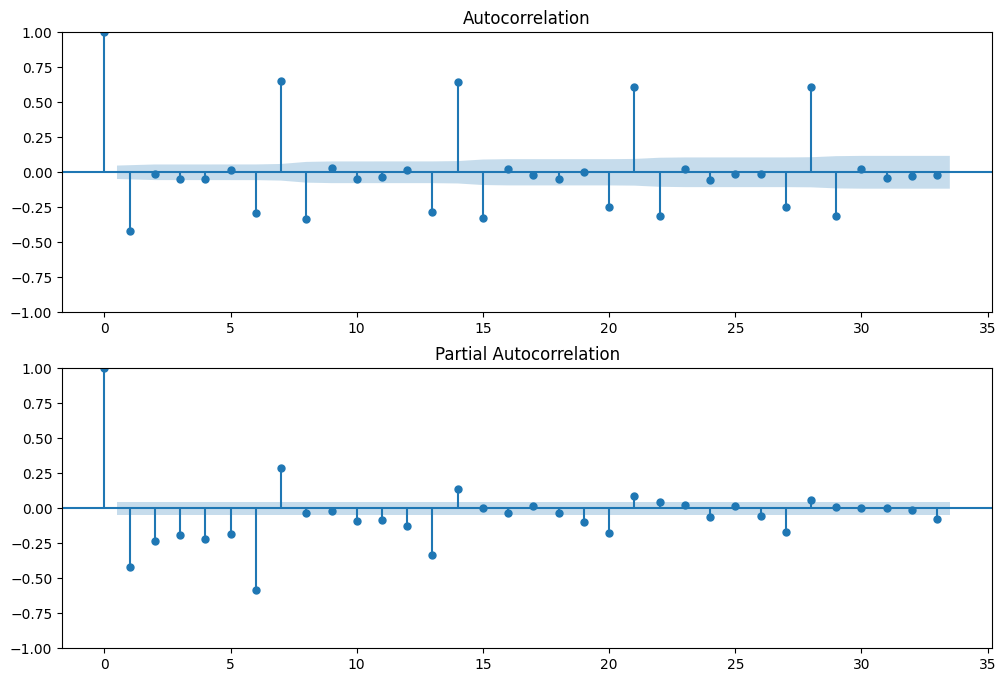

In [37]:
fig, ax = plt.subplots(2,1,figsize=(12,8))
plot_acf(sales_diff, ax=ax[0])
plot_pacf(sales_diff, ax=ax[1])
plt.show()

In [38]:
arima_model = auto_arima(train, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True, max_p=3, max_q=3, max_d=1, maxiter=50)
arima_forecast = arima_model.predict(n_periods=val_length)
arima_forecast = pd.Series(arima_forecast, index=val.index)
print(f"NaN in arima_forecast: {arima_forecast.isna().sum()}")
if arima_forecast.isna().any():
    arima_forecast = arima_forecast.fillna(method='ffill')
print(f"ARIMA forecast range: min={arima_forecast.min():.2f}, max={arima_forecast.max():.2f}")
if (arima_forecast < 0).any():
    print(f"Negative values in arima_forecast: {(arima_forecast < 0).sum()}")
    arima_forecast = arima_forecast.clip(lower=0)
# Check forecast length
if len(arima_forecast) != val_length:
    print(f"Warning: Forecast length ({len(arima_forecast)}) does not match val_length ({val_length})")

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.80 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=27508.221, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=27185.607, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=27506.227, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=27095.266, Time=0.12 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=27033.110, Time=0.24 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=2.20 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.42 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=27031.113, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=27093.269, Time=0.10 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=26649.988, Time=1.32 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=26657.491, Time=0.89 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=26598.566, Time=1.67 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=2

In [39]:
sarima_model = auto_arima(train, seasonal=True, m=7, trace=True, error_action='ignore', suppress_warnings=True, max_p=3, max_q=3, max_P=2, max_Q=2, max_d=1, max_D=1, maxiter=50)
sarima_forecast = sarima_model.predict(n_periods=val_length)
sarima_forecast = pd.Series(sarima_forecast, index=val.index)
print(f"NaN in sarima_forecast: {sarima_forecast.isna().sum()}")
if sarima_forecast.isna().any():
    sarima_forecast = sarima_forecast.fillna(method='ffill')
print(f"SARIMA forecast range: min={sarima_forecast.min():.2f}, max={sarima_forecast.max():.2f}")
if (sarima_forecast < 0).any():
    print(f"Negative values in sarima_forecast: {(sarima_forecast < 0).sum()}")
    sarima_forecast = sarima_forecast.clip(lower=0)
if len(sarima_forecast) != val_length:
    print(f"Warning: Forecast length ({len(sarima_forecast)}) does not match val_length ({val_length})")

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=7.80 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=27508.221, Time=0.06 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=26377.697, Time=1.40 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=inf, Time=1.89 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=27506.227, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=27185.607, Time=0.12 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=26122.378, Time=3.07 sec
 ARIMA(1,1,0)(2,0,1)[7] intercept   : AIC=25917.950, Time=11.75 sec
 ARIMA(1,1,0)(1,0,1)[7] intercept   : AIC=25916.839, Time=5.10 sec
 ARIMA(1,1,0)(0,0,1)[7] intercept   : AIC=26757.507, Time=1.40 sec
 ARIMA(1,1,0)(1,0,2)[7] intercept   : AIC=inf, Time=12.43 sec
 ARIMA(1,1,0)(0,0,2)[7] intercept   : AIC=26531.593, Time=2.90 sec
 ARIMA(1,1,0)(2,0,2)[7] intercept   : AIC=inf, Time=15.93 sec
 ARIMA(0,1,0)(1,0,1)[7] intercept   : AIC=26144.666, Time=4.02 sec
 ARIMA(2,1,0)(1,0,1)[7] intercept   : AI

In [26]:
def create_features(series):
    series = pd.Series(series, index=series.index, name='sales').copy()
    print(f"Input series dtype: {series.dtype}")
    features = pd.DataFrame({'sales': series})
    features['lag1'] = series.shift(1)
    features['lag7'] = series.shift(7)
    features['rolling_mean7'] = series.rolling(7).mean()
    features['dayofweek'] = series.index.dayofweek
    features['month'] = series.index.month
    features['year'] = series.index.year
    return features.fillna(method='ffill')

In [40]:
def create_features(series):
    series = pd.Series(series, index=series.index, name='sales').copy()
    print(f"Input series dtype: {series.dtype}")
    features = pd.DataFrame({'sales': series})
    features['lag1'] = series.shift(1)
    features['lag7'] = series.shift(7)
    features['rolling_mean7'] = series.rolling(7).mean()
    features['dayofweek'] = series.index.dayofweek
    features['month'] = series.index.month
    features['year'] = series.index.year
    return features.fillna(method='ffill')

sales_features = create_features(sales)
print(f"Sales_features dtypes:\n{sales_features.dtypes}")
train_features = sales_features.loc[:train_end].dropna()
X_train = train_features.drop('sales', axis=1)
y_train = train_features['sales']
params = {'objective': 'regression', 'metric': 'rmse', 'verbosity': -1, 'learning_rate': 0.1, 'num_leaves': 31, 'n_estimators': 200}
dataset = lgb.Dataset(X_train, y_train)
model_lgb = lgb.train(params, dataset, num_boost_round=200)
lgb_forecasts = []
current_series = sales.loc[:train_end].copy()
for i in range(val_length):
    current_features = create_features(current_series)
    X_current = current_features.drop('sales', axis=1).iloc[-1:]
    pred = model_lgb.predict(X_current)[0]
    lgb_forecasts.append(pred)
    new_date = current_series.index[-1] + pd.Timedelta(days=1)
    current_series.loc[new_date] = pred
lgb_forecast = pd.Series(lgb_forecasts, index=val.index)
print(f"NaN in lgb_forecast: {lgb_forecast.isna().sum()}")
if lgb_forecast.isna().any():
    lgb_forecast = lgb_forecast.fillna(method='ffill')
print(f"LightGBM forecast range: min={lgb_forecast.min():.2f}, max={lgb_forecast.max():.2f}")
if (lgb_forecast < 0).any():
    print(f"Negative values in lgb_forecast: {(lgb_forecast < 0).sum()}")
    lgb_forecast = lgb_forecast.clip(lower=0)
if len(lgb_forecast) != val_length:
    print(f"Warning: Forecast length ({len(lgb_forecast)}) does not match val_length ({val_length})")

Input series dtype: float64
Sales_features dtypes:
sales            float64
lag1             float64
lag7             float64
rolling_mean7    float64
dayofweek          int32
month              int32
year               int32
dtype: object
Input series dtype: float64
Input series dtype: float64
Input series dtype: float64
Input series dtype: float64
Input series dtype: float64
Input series dtype: float64
Input series dtype: float64
Input series dtype: float64
Input series dtype: float64
Input series dtype: float64
Input series dtype: float64
Input series dtype: float64
Input series dtype: float64
Input series dtype: float64
Input series dtype: float64
NaN in lgb_forecast: 0
LightGBM forecast range: min=929.04, max=3061.44


In [41]:
def calculate_errors(y_true, y_pred):
    df = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
    original_length = len(df)
    df = df.dropna()
    if df.empty:
        print(f"Warning: All {original_length} pairs dropped due to NaN")
        return {'MAE': np.nan, 'MSE': np.nan, 'RMSE': np.nan, 'MAPE': np.nan}
    y_true_clean = df['y_true']
    y_pred_clean = df['y_pred']
    mae = mean_absolute_error(y_true_clean, y_pred_clean)
    mse = mean_squared_error(y_true_clean, y_pred_clean)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true_clean, y_pred_clean)
    return {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'MAPE': mape}

# Naive baseline: repeat last train value
naive_forecast = pd.Series([train.iloc[-1]] * val_length, index=val.index)
naive_errors = calculate_errors(val, naive_forecast)

arima_errors = calculate_errors(val, arima_forecast)
sarima_errors = calculate_errors(val, sarima_forecast)
lgb_errors = calculate_errors(val, lgb_forecast)

errors_df = pd.DataFrame({
    'Naive': naive_errors,
    'ARIMA': arima_errors,
    'SARIMA': sarima_errors,
    'LightGBM': lgb_errors
}).T
print("Forecasting Errors Comparison (Validation):")
print(errors_df)
# Diagnostic check
print(f"Val std: {val.std():.2f}")
if errors_df['RMSE'].min() > val.std() * 2:
    print("Warning: Minimum RMSE exceeds twice the validation standard deviation")

Forecasting Errors Comparison (Validation):
                 MAE           MSE         RMSE      MAPE
Naive     761.400000  1.000306e+06  1000.153155  0.534421
ARIMA            NaN           NaN          NaN       NaN
SARIMA           NaN           NaN          NaN       NaN
LightGBM  766.898861  8.204470e+05   905.785288  0.469170
Val std: 727.96


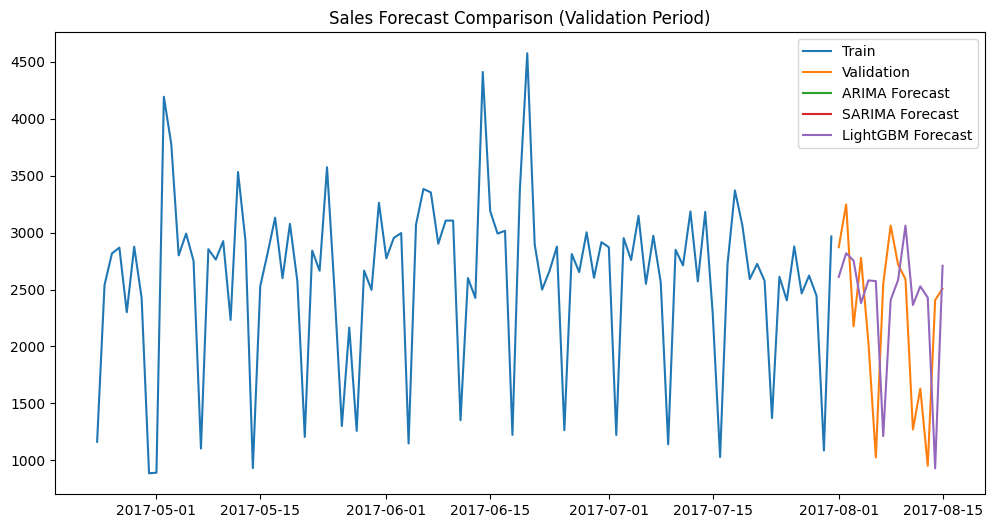

In [42]:
plt.figure(figsize=(12,6))
plt.plot(train[-100:], label='Train')
plt.plot(val, label='Validation')
plt.plot(arima_forecast, label='ARIMA Forecast')
plt.plot(sarima_forecast, label='SARIMA Forecast')
plt.plot(lgb_forecast, label='LightGBM Forecast')
plt.legend()
plt.title('Sales Forecast Comparison (Validation Period)')
plt.show()

In [43]:
full_sales = sales.copy()
arima_full = auto_arima(full_sales, seasonal=False, trace=True, error_action='ignore', suppress_warnings=True)
sarima_full = auto_arima(full_sales, seasonal=True, m=7, trace=True, error_action='ignore', suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.84 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=27752.829, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=27429.568, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.40 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=27750.834, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=27339.762, Time=0.21 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=27276.293, Time=0.27 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=27194.218, Time=0.89 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=27136.628, Time=0.59 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=26884.538, Time=4.46 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=26881.994, Time=4.10 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=2.37 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=26782.625, Time=3.92 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.14 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=i

In [44]:
sales_features_full = create_features(full_sales).dropna()
X_full = sales_features_full.drop('sales', axis=1)
y_full = sales_features_full['sales']
dataset_full = lgb.Dataset(X_full, y_full)
model_lgb_full = lgb.train(params, dataset_full, num_boost_round=100)

Input series dtype: float64


In [45]:
future_steps = 60
future_dates = pd.date_range(start=full_sales.index[-1] + pd.Timedelta(days=1), periods=future_steps, freq='D')
arima_future = arima_full.predict(n_periods=future_steps)
arima_future = pd.Series(arima_future, index=future_dates)
sarima_future = sarima_full.predict(n_periods=future_steps)
sarima_future = pd.Series(sarima_future, index=future_dates)
lgb_future_forecasts = []
current_series = full_sales.copy()
for i in range(future_steps):
    current_features = create_features(current_series)
    X_current = current_features.drop('sales', axis=1).iloc[-1:]
    pred = model_lgb_full.predict(X_current)[0]
    lgb_future_forecasts.append(pred)
    new_date = current_series.index[-1] + pd.Timedelta(days=1)
    current_series.loc[new_date] = pred
lgb_future = pd.Series(lgb_future_forecasts, index=future_dates)

Input series dtype: float64
Input series dtype: float64
Input series dtype: float64
Input series dtype: float64
Input series dtype: float64
Input series dtype: float64
Input series dtype: float64
Input series dtype: float64
Input series dtype: float64
Input series dtype: float64
Input series dtype: float64
Input series dtype: float64
Input series dtype: float64
Input series dtype: float64
Input series dtype: float64
Input series dtype: float64
Input series dtype: float64
Input series dtype: float64
Input series dtype: float64
Input series dtype: float64
Input series dtype: float64
Input series dtype: float64
Input series dtype: float64
Input series dtype: float64
Input series dtype: float64
Input series dtype: float64
Input series dtype: float64
Input series dtype: float64
Input series dtype: float64
Input series dtype: float64
Input series dtype: float64
Input series dtype: float64
Input series dtype: float64
Input series dtype: float64
Input series dtype: float64
Input series dtype: 

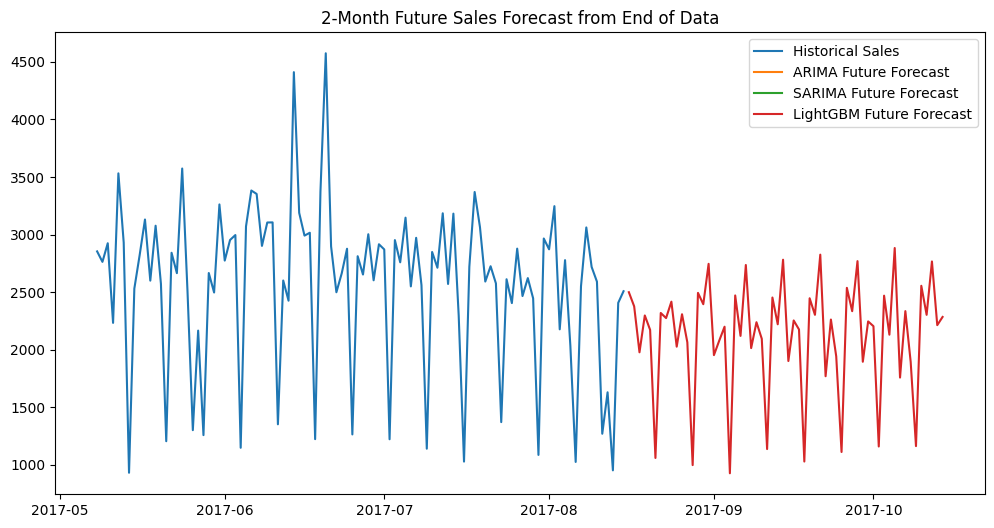

In [46]:
plt.figure(figsize=(12,6))
plt.plot(full_sales[-100:], label='Historical Sales')
plt.plot(arima_future, label='ARIMA Future Forecast')
plt.plot(sarima_future, label='SARIMA Future Forecast')
plt.plot(lgb_future, label='LightGBM Future Forecast')
plt.legend()
plt.title('2-Month Future Sales Forecast from End of Data')
plt.show()

In [47]:
import os, glob, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from pmdarima import auto_arima
import lightgbm as lgb

warnings.filterwarnings("ignore")
pd.set_option("display.width", 160)
pd.set_option("display.max_columns", 50)


In [48]:
# Tries common Kaggle paths first, then local files.
candidates = [
    "/kaggle/input/store-sales-time-series-forecasting/train.csv",
    "/kaggle/input/store-sales-time-seri*/train.csv",
    "train.csv",              # same columns as Kaggle: date, store_nbr, family, sales, onpromotion...
    "sales.csv"               # fallback with columns: date, sales
]

csv_path = None
for pat in candidates:
    matches = glob.glob(pat)
    if matches:
        csv_path = matches[0]
        break

if csv_path is None:
    raise FileNotFoundError(
        "Data not found. Put Kaggle train.csv or a sales.csv with columns ['date','sales'] next to the notebook."
    )

print(f"Using data: {csv_path}")

df = pd.read_csv(csv_path, parse_dates=["date"])
if "sales" not in df.columns:
    raise ValueError("Input must contain a 'sales' column.")

# If it's Kaggle's train.csv, aggregate total sales by date
if "store_nbr" in df.columns or "family" in df.columns:
    s = df.groupby("date")["sales"].sum()
else:
    s = df.set_index("date")["sales"]

sales = s.sort_index().asfreq("D")
# In the Kaggle dataset there are usually no missing days, but fill just in case:
sales = sales.fillna(0.0)

print(sales.head(), "\n")
print(f"Date range: {sales.index.min().date()} → {sales.index.max().date()}  |  n={len(sales)}")


Using data: /kaggle/input/store-sales-time-series-forecasting/train.csv
date
2013-01-01      2511.618999
2013-01-02    496092.417944
2013-01-03    361461.231124
2013-01-04    354459.677093
2013-01-05    477350.121229
Freq: D, Name: sales, dtype: float64 

Date range: 2013-01-01 → 2017-08-15  |  n=1688


In [49]:
prefer_cut = pd.Timestamp("2017-07-31")
if sales.index.min() <= prefer_cut <= sales.index.max():
    train_end = prefer_cut
else:
    # Fallback: last 90 days as validation
    train_end = sales.index[-91]

train = sales.loc[:train_end]
val = sales.loc[train_end + pd.Timedelta(days=1):]
val_length = len(val)

print(f"Train: {train.index.min().date()} → {train.index.max().date()}  (n={len(train)})")
print(f"Val  : {val.index.min().date()} → {val.index.max().date()}  (n={len(val)})")


Train: 2013-01-01 → 2017-07-31  (n=1673)
Val  : 2017-08-01 → 2017-08-15  (n=15)


In [50]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(series, title=""):
    result = adfuller(series.dropna(), autolag="AIC")
    print(f"ADF Test {title}".strip())
    print(f"  ADF Statistic: {result[0]:.4f}")
    print(f"  p-value      : {result[1]:.6f}")
    print("  Critical Values:")
    for k, v in result[4].items():
        print(f"    {k:>6}: {v:.4f}")
    print()

print("Stationarity on TRAIN:")
test_stationarity(train, "(train)")

sales_diff = train.diff().dropna()
print("Stationarity on differenced TRAIN:")
test_stationarity(sales_diff, "(diff(train))")


Stationarity on TRAIN:
ADF Test (train)
  ADF Statistic: -2.4956
  p-value      : 0.116553
  Critical Values:
        1%: -3.4343
        5%: -2.8633
       10%: -2.5677

Stationarity on differenced TRAIN:
ADF Test (diff(train))
  ADF Statistic: -11.2252
  p-value      : 0.000000
  Critical Values:
        1%: -3.4343
        5%: -2.8633
       10%: -2.5677



In [51]:
print("Fitting ARIMA (non-seasonal) on train...")
arima_model = auto_arima(
    train,
    seasonal=False,
    stepwise=True,
    trace=False,
    error_action="ignore",
    suppress_warnings=True
)

arima_forecast = pd.Series(arima_model.predict(n_periods=val_length), index=val.index)
# Sanity
arima_forecast = arima_forecast.fillna(method="ffill").clip(lower=0)

print(arima_model.summary())
print("\nARIMA validation forecast ready.")


Fitting ARIMA (non-seasonal) on train...
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1673
Model:               SARIMAX(0, 1, 2)   Log Likelihood              -22207.735
Date:                Fri, 15 Aug 2025   AIC                          44421.471
Time:                        14:14:36   BIC                          44437.736
Sample:                    01-01-2013   HQIC                         44427.497
                         - 07-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4551      0.012    -38.678      0.000      -0.478      -0.432
ma.L2         -0.4744      0.011    -44.712      0.000      -0.495      -0.454
sigma2     

In [52]:
print("Fitting SARIMA (seasonal m=7) on train...")
sarima_model = auto_arima(
    train,
    seasonal=True,
    m=7,               # weekly seasonality for daily data
    stepwise=True,
    trace=False,
    error_action="ignore",
    suppress_warnings=True
)

sarima_forecast = pd.Series(sarima_model.predict(n_periods=val_length), index=val.index)
sarima_forecast = sarima_forecast.fillna(method="ffill").clip(lower=0)

print(sarima_model.summary())
print("\nSARIMA validation forecast ready.")


Fitting SARIMA (seasonal m=7) on train...
                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 1673
Model:             SARIMAX(4, 1, 2)x(1, 0, 2, 7)   Log Likelihood              -21747.771
Date:                           Fri, 15 Aug 2025   AIC                          43517.543
Time:                                   14:20:07   BIC                          43577.182
Sample:                               01-01-2013   HQIC                         43539.640
                                    - 07-31-2017                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1410.2814    709.690      1.987      0.047      19.314    2801.249
a

In [53]:
def create_features(series: pd.Series) -> pd.DataFrame:
    series = pd.Series(series, index=series.index, name="sales").copy()
    feat = pd.DataFrame({"sales": series})
    # Lags
    feat["lag1"] = series.shift(1)
    feat["lag7"] = series.shift(7)
    # FIX: shift BEFORE rolling to avoid leakage
    feat["rolling_mean7"] = series.shift(1).rolling(7).mean()
    # Calendar
    idx = series.index
    feat["dayofweek"] = idx.dayofweek
    feat["month"] = idx.month
    feat["year"] = idx.year
    return feat


In [54]:
train_features = create_features(train).dropna()
X_train = train_features.drop(columns=["sales"])
y_train = train_features["sales"]

params = {
    "objective": "regression",
    "metric": "rmse",
    "verbosity": -1,
    "learning_rate": 0.1,
    "num_leaves": 31,
    "n_estimators": 200
}

lgb_train = lgb.Dataset(X_train, y_train)
model_lgb = lgb.train(params, lgb_train, num_boost_round=200)

# Iterative one-step-ahead forecasting
lgb_forecasts = []
current_series = train.copy()

for _ in range(val_length):
    next_date = current_series.index[-1] + pd.Timedelta(days=1)
    tmp = current_series.copy()
    tmp.loc[next_date] = np.nan  # placeholder
    X_next = create_features(tmp).drop(columns=["sales"]).loc[[next_date]]
    pred = float(model_lgb.predict(X_next)[0])
    lgb_forecasts.append(pred)
    current_series.loc[next_date] = pred  # feed prediction

lgb_forecast = pd.Series(lgb_forecasts, index=val.index)
lgb_forecast = lgb_forecast.fillna(method="ffill").clip(lower=0)

print("LightGBM validation forecast ready.")


LightGBM validation forecast ready.


In [55]:
def metrics(y_true, y_pred):
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae  = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    return rmse, mae, mape

results = []
for name, yhat in [
    ("ARIMA", arima_forecast),
    ("SARIMA", sarima_forecast),
    ("LightGBM", lgb_forecast),
]:
    rmse, mae, mape = metrics(val.values, yhat.values)
    results.append((name, rmse, mae, mape))

metrics_df = pd.DataFrame(results, columns=["Model", "RMSE", "MAE", "MAPE"]).sort_values("RMSE")
print(metrics_df.to_string(index=False))


   Model          RMSE           MAE     MAPE
   ARIMA 117628.381195 103033.516711 0.126952
LightGBM 140210.526345 107706.076241 0.125675
  SARIMA 172959.643583 150920.745728 0.184326


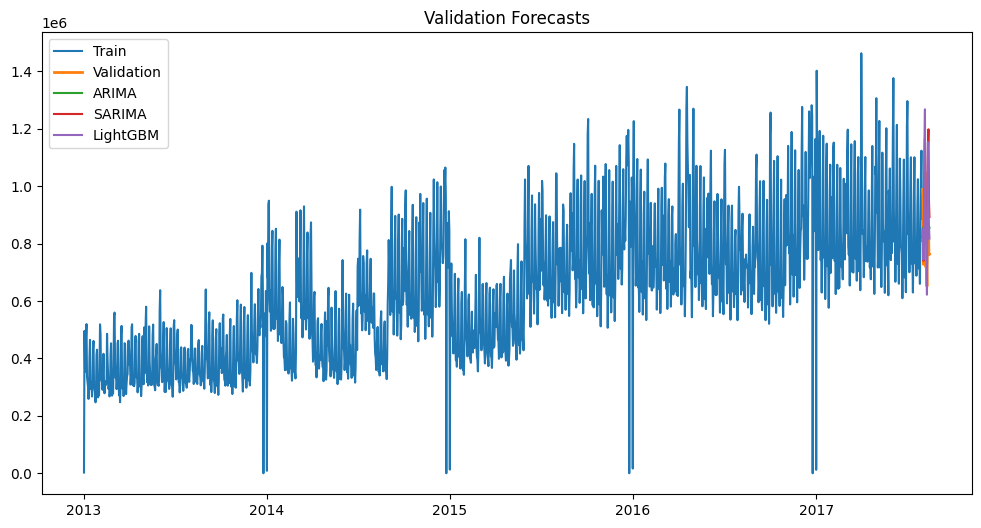

In [56]:
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label="Train")
plt.plot(val.index, val, label="Validation", linewidth=2)
plt.plot(arima_forecast.index, arima_forecast, label="ARIMA")
plt.plot(sarima_forecast.index, sarima_forecast, label="SARIMA")
plt.plot(lgb_forecast.index, lgb_forecast, label="LightGBM")
plt.legend()
plt.title("Validation Forecasts")
plt.show()


In [57]:
full_sales = sales.copy()

print("Fitting full ARIMA...")
arima_full = auto_arima(
    full_sales,
    seasonal=False,
    stepwise=True,
    trace=False,
    error_action="ignore",
    suppress_warnings=True
)

print("Fitting full SARIMA (m=7)...")
sarima_full = auto_arima(
    full_sales,
    seasonal=True,
    m=7,
    stepwise=True,
    trace=False,
    error_action="ignore",
    suppress_warnings=True
)

print("Full ARIMA/SARIMA models ready.")


Fitting full ARIMA...
Fitting full SARIMA (m=7)...
Full ARIMA/SARIMA models ready.


In [58]:
features_full = create_features(full_sales).dropna()
X_full = features_full.drop(columns=["sales"])
y_full = features_full["sales"]
lgb_full = lgb.Dataset(X_full, y_full)

# reuse params; adjust rounds if you like
model_lgb_full = lgb.train(params, lgb_full, num_boost_round=200)
print("Full LightGBM model ready.")


Full LightGBM model ready.


In [59]:
future_steps = 60  # change as needed

# ARIMA & SARIMA future
arima_future = pd.Series(arima_full.predict(n_periods=future_steps),
                         index=pd.date_range(sales.index[-1] + pd.Timedelta(days=1), periods=future_steps, freq="D"))
sarima_future = pd.Series(sarima_full.predict(n_periods=future_steps),
                          index=arima_future.index)

# LightGBM iterative future
lgb_future_values = []
current_series = sales.copy()
for _ in range(future_steps):
    next_date = current_series.index[-1] + pd.Timedelta(days=1)
    tmp = current_series.copy()
    tmp.loc[next_date] = np.nan
    X_next = create_features(tmp).drop(columns=["sales"]).loc[[next_date]]
    pred = float(model_lgb_full.predict(X_next)[0])
    lgb_future_values.append(pred)
    current_series.loc[next_date] = pred

lgb_future = pd.Series(lgb_future_values, index=arima_future.index)

# Clean-ups
arima_future = arima_future.fillna(method="ffill").clip(lower=0)
sarima_future = sarima_future.fillna(method="ffill").clip(lower=0)
lgb_future   = lgb_future.fillna(method="ffill").clip(lower=0)

print("Future forecasts ready.")


Future forecasts ready.


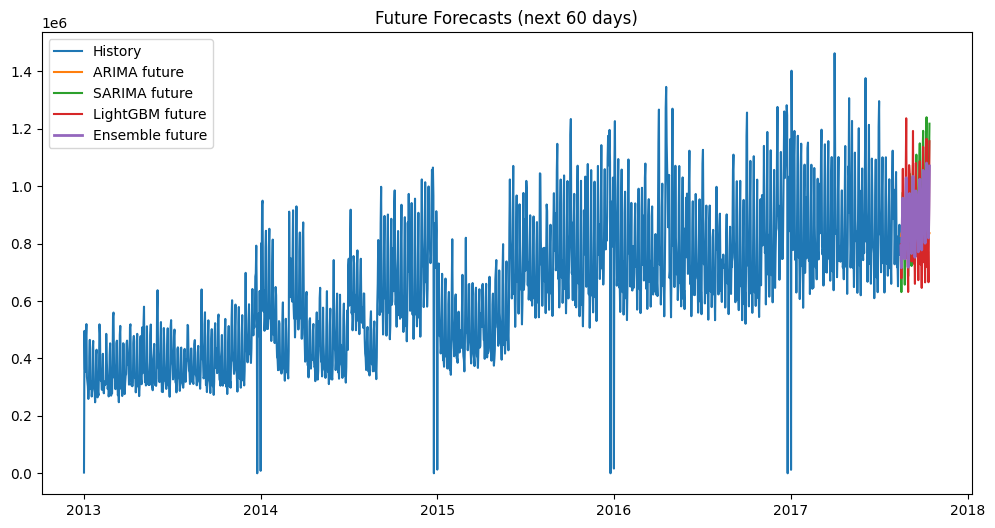

In [60]:
# Simple average ensemble
ensemble_future = (arima_future + sarima_future + lgb_future) / 3.0

plt.figure(figsize=(12, 6))
plt.plot(sales.index, sales, label="History")
plt.plot(arima_future.index, arima_future, label="ARIMA future")
plt.plot(sarima_future.index, sarima_future, label="SARIMA future")
plt.plot(lgb_future.index, lgb_future, label="LightGBM future")
plt.plot(ensemble_future.index, ensemble_future, label="Ensemble future", linewidth=2)
plt.legend()
plt.title("Future Forecasts (next 60 days)")
plt.show()


In [61]:
out = pd.DataFrame({
    "date": arima_future.index,
    "arima": arima_future.values,
    "sarima": sarima_future.values,
    "lgbm": lgb_future.values,
    "ensemble": ensemble_future.values
})
out.to_csv("future_forecasts.csv", index=False)
out.head()


,date,arima,sarima,lgbm,ensemble
0,2017-08-16,826745.088239,751335.675856,7.973587e+05,791813.170541
1,2017-08-17,836583.781508,631225.375810,6.792720e+05,715693.728888
2,2017-08-18,836583.781508,773663.391265,7.772395e+05,795828.902830
3,2017-08-19,836583.781508,895835.774060,9.336649e+05,888694.817956
4,2017-08-20,836583.781508,978758.846031,1.060520e+06,958620.769348


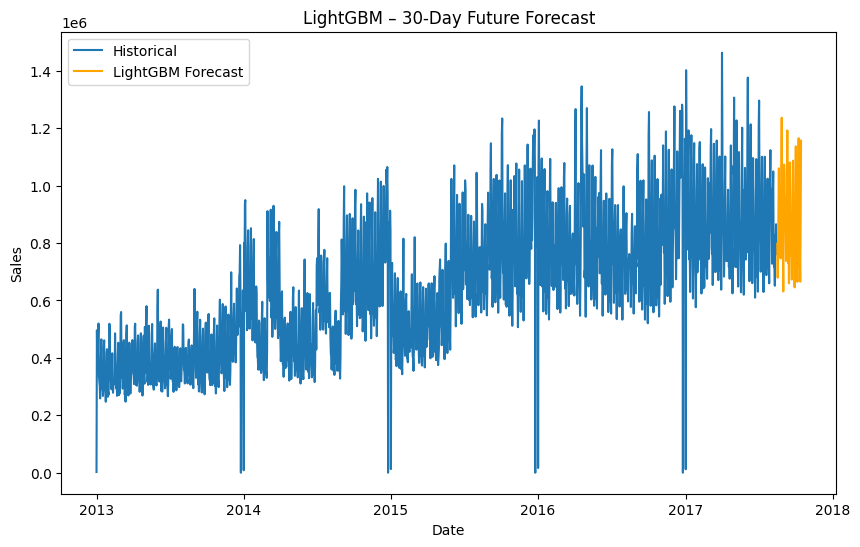

In [62]:
plt.figure(figsize=(10, 6))
plt.plot(sales.index, sales, label='Historical')
plt.plot(lgb_future.index, lgb_future, label='LightGBM Forecast', color='orange')
plt.title("LightGBM – 30-Day Future Forecast")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()


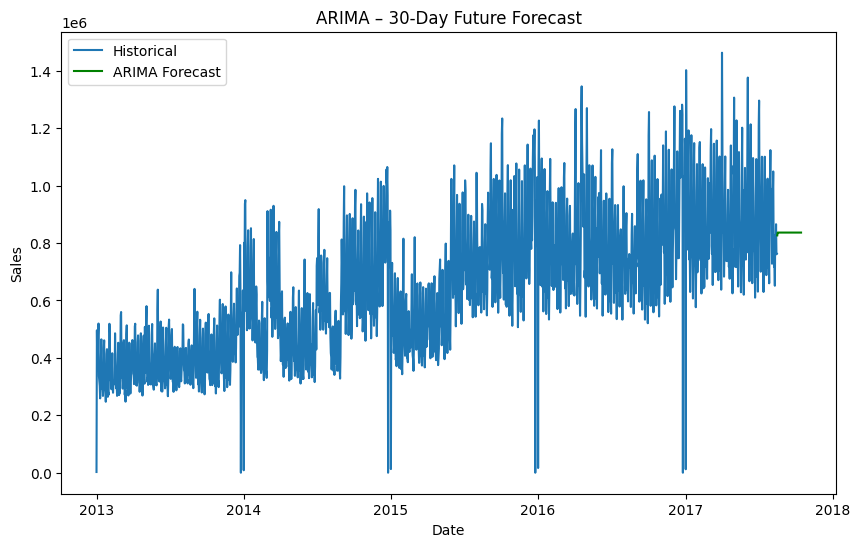

In [63]:
plt.figure(figsize=(10, 6))
plt.plot(sales.index, sales, label='Historical')
plt.plot(arima_future.index, arima_future, label='ARIMA Forecast', color='green')
plt.title("ARIMA – 30-Day Future Forecast")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()


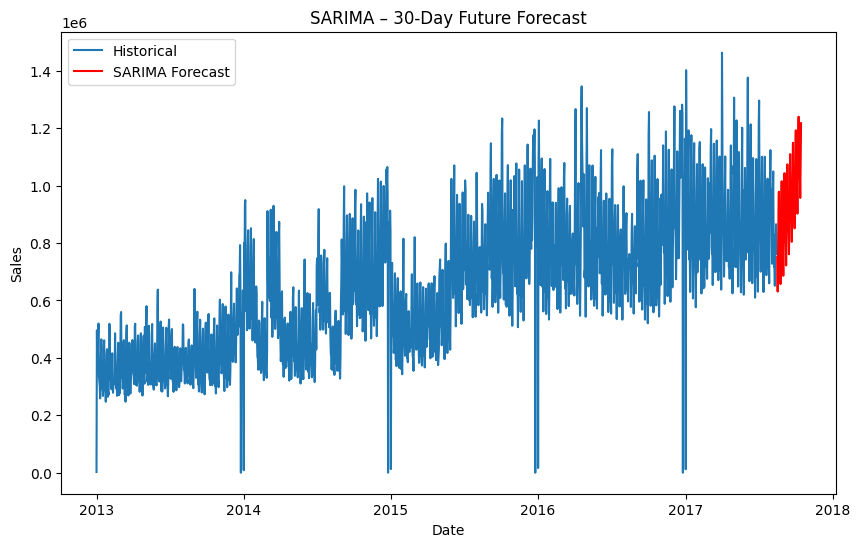

In [64]:
plt.figure(figsize=(10, 6))
plt.plot(sales.index, sales, label='Historical')
plt.plot(sarima_future.index, sarima_future, label='SARIMA Forecast', color='red')
plt.title("SARIMA – 30-Day Future Forecast")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()


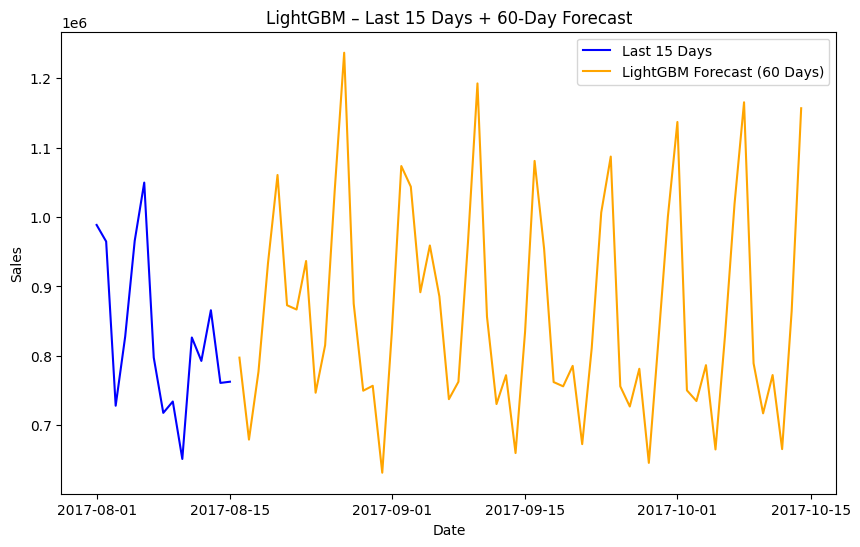

In [65]:
plt.figure(figsize=(10, 6))
plt.plot(sales.index[-15:], sales[-15:], label='Last 15 Days', color='blue')
plt.plot(lgb_future.index, lgb_future, label='LightGBM Forecast (60 Days)', color='orange')
plt.title("LightGBM – Last 15 Days + 60-Day Forecast")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()


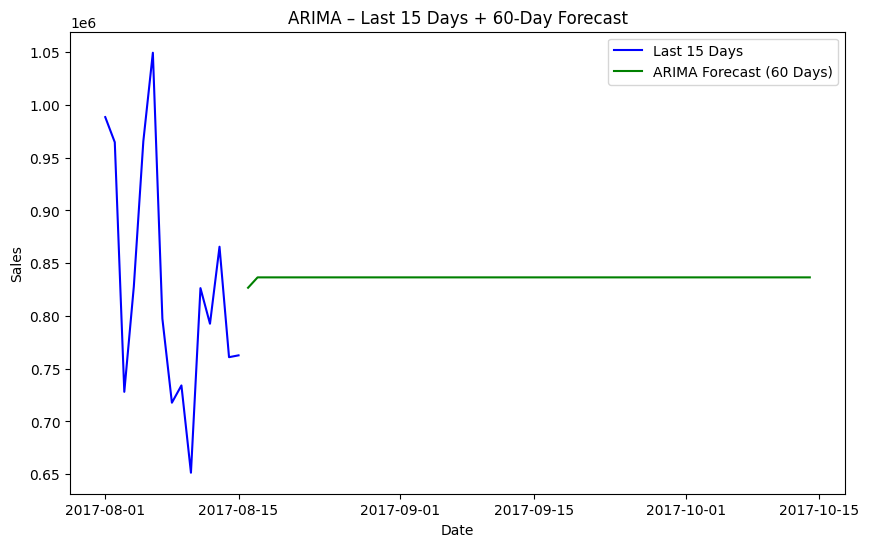

In [66]:
plt.figure(figsize=(10, 6))
plt.plot(sales.index[-15:], sales[-15:], label='Last 15 Days', color='blue')
plt.plot(arima_future.index, arima_future, label='ARIMA Forecast (60 Days)', color='green')
plt.title("ARIMA – Last 15 Days + 60-Day Forecast")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()


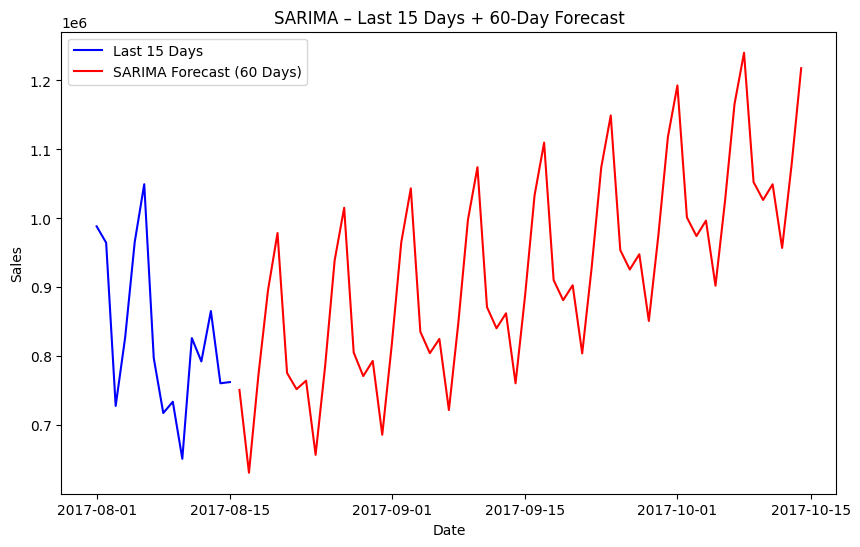

In [67]:
plt.figure(figsize=(10, 6))
plt.plot(sales.index[-15:], sales[-15:], label='Last 15 Days', color='blue')
plt.plot(sarima_future.index, sarima_future, label='SARIMA Forecast (60 Days)', color='red')
plt.title("SARIMA – Last 15 Days + 60-Day Forecast")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.show()


In [68]:
# Cell A: quick checks
needed = {
    'sales': 'historical series (pd.Series)',
    'train': 'train series',
    'val': 'validation series',
    'arima_forecast': 'ARIMA validation forecast (pd.Series indexed by val)',
    'sarima_forecast': 'SARIMA validation forecast (pd.Series indexed by val)',
    'lgb_forecast': 'LightGBM validation forecast (pd.Series indexed by val)',
    'arima_future': 'ARIMA future forecast (pd.DatetimeIndex)',
    'sarima_future': 'SARIMA future forecast',
    'lgb_future': 'LightGBM future forecast'
}
for v, desc in needed.items():
    exists = v in globals()
    print(f"{v:15} : {'FOUND' if exists else 'MISSING':7}  -- {desc}")
    if exists:
        obj = globals()[v]
        try:
            print("   type:", type(obj), "len:", len(obj))
            if hasattr(obj, 'index'):
                print("   index range:", obj.index.min(), "->", obj.index.max())
        except Exception:
            pass
print("\nValidation index (val) sample:", None if 'val' not in globals() else (val.index.min(), val.index.max()))


sales           : FOUND    -- historical series (pd.Series)
   type: <class 'pandas.core.series.Series'> len: 1688
   index range: 2013-01-01 00:00:00 -> 2017-08-15 00:00:00
train           : FOUND    -- train series
   type: <class 'pandas.core.series.Series'> len: 1673
   index range: 2013-01-01 00:00:00 -> 2017-07-31 00:00:00
val             : FOUND    -- validation series
   type: <class 'pandas.core.series.Series'> len: 15
   index range: 2017-08-01 00:00:00 -> 2017-08-15 00:00:00
arima_forecast  : FOUND    -- ARIMA validation forecast (pd.Series indexed by val)
   type: <class 'pandas.core.series.Series'> len: 15
   index range: 2017-08-01 00:00:00 -> 2017-08-15 00:00:00
sarima_forecast : FOUND    -- SARIMA validation forecast (pd.Series indexed by val)
   type: <class 'pandas.core.series.Series'> len: 15
   index range: 2017-08-01 00:00:00 -> 2017-08-15 00:00:00
lgb_forecast    : FOUND    -- LightGBM validation forecast (pd.Series indexed by val)
   type: <class 'pandas.core.ser

In [69]:
# Cell B: evaluation metrics for each model vs val
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error

def safe_mape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    denom = np.where(y_true == 0, 1.0, y_true)   # avoid divide-by-zero
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100

results = []
models = [('ARIMA', 'arima_forecast'), ('SARIMA', 'sarima_forecast'), ('LightGBM', 'lgb_forecast')]
for name, varname in models:
    if varname in globals():
        yhat = globals()[varname]
        # align to val index if needed
        if isinstance(yhat, pd.Series):
            if not yhat.index.equals(val.index):
                yhat = yhat.reindex(val.index).fillna(method='ffill')
        else:  # numpy array
            yhat = pd.Series(yhat, index=val.index)
        rmse = mean_squared_error(val.values, yhat.values, squared=False)
        mae = mean_absolute_error(val.values, yhat.values)
        mape = safe_mape(val.values, yhat.values)
        results.append((name, rmse, mae, mape))
    else:
        print(f"{name} forecast not found as variable '{varname}'")

if results:
    df_res = pd.DataFrame(results, columns=['Model','RMSE','MAE','MAPE']).sort_values('RMSE')
    print(df_res.to_string(index=False))
else:
    print("No forecasts found to evaluate.")


   Model          RMSE           MAE      MAPE
   ARIMA 117628.381195 103033.516711 12.695226
LightGBM 140210.526345 107706.076241 12.567518
  SARIMA 172959.643583 150920.745728 18.432597


In [70]:
# Cell C: naive baseline (persistence: last observed value of train)
import numpy as np
from sklearn.metrics import mean_squared_error
last_val = train.iloc[-1]
naive = np.repeat(last_val, len(val))
naive_rmse = mean_squared_error(val.values, naive, squared=False)
print(f"Naive persistence RMSE: {naive_rmse:.4f}")
# if models exist, show delta against naive:
if 'df_res' in globals():
    df_res['Improvement_vs_Naive_RMSE'] = (naive_rmse - df_res['RMSE']).round(4)
    print("\nComparison vs naive persistence:")
    print(df_res.to_string(index=False))


Naive persistence RMSE: 125349.6204

Comparison vs naive persistence:
   Model          RMSE           MAE      MAPE  Improvement_vs_Naive_RMSE
   ARIMA 117628.381195 103033.516711 12.695226                  7721.2392
LightGBM 140210.526345 107706.076241 12.567518                -14860.9060
  SARIMA 172959.643583 150920.745728 18.432597                -47610.0232


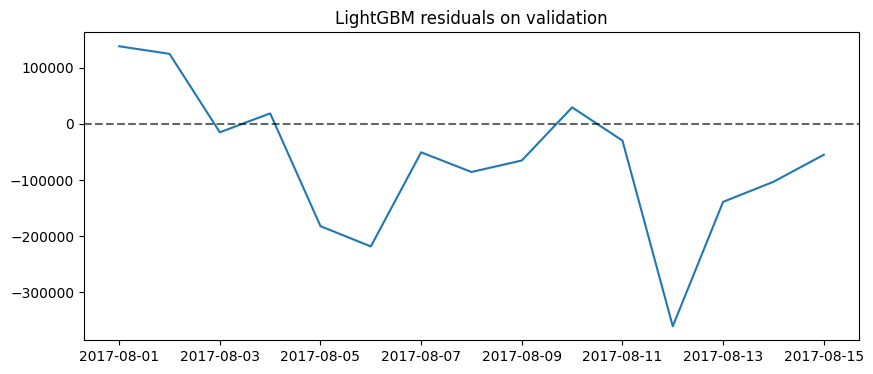

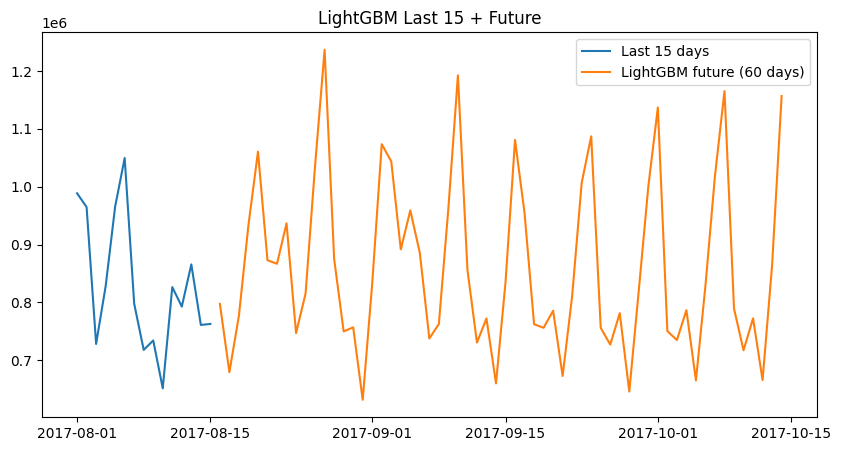

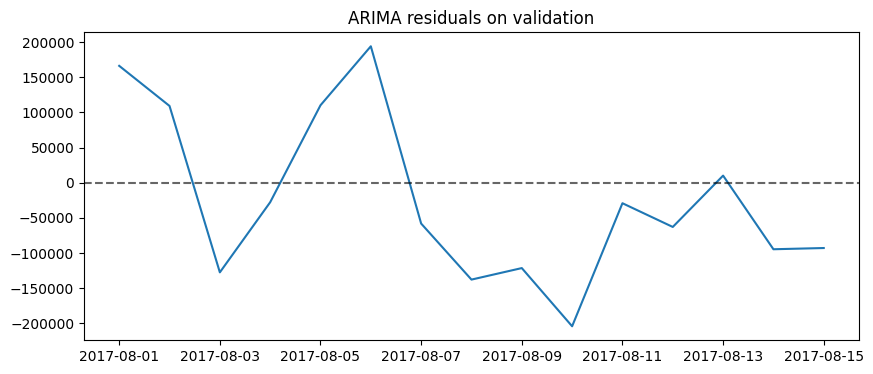

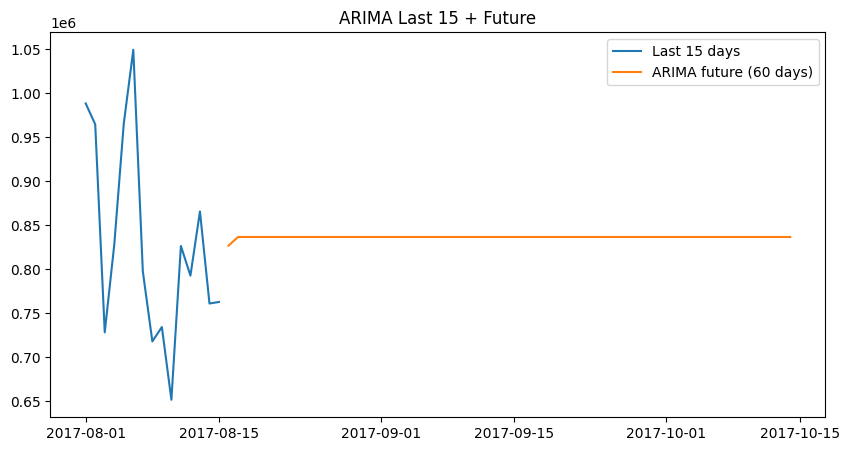

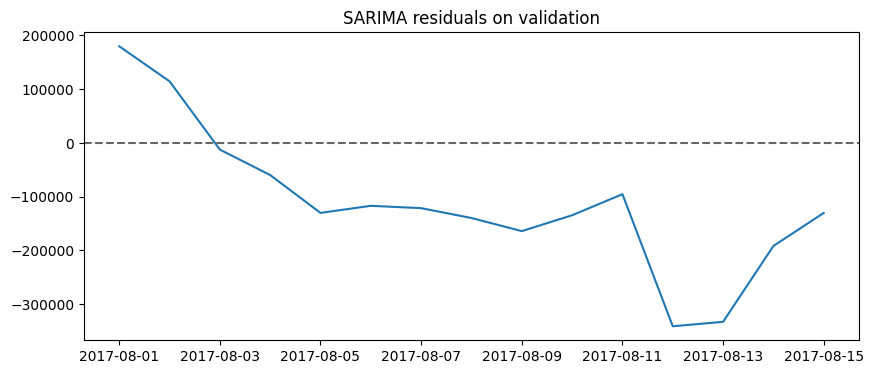

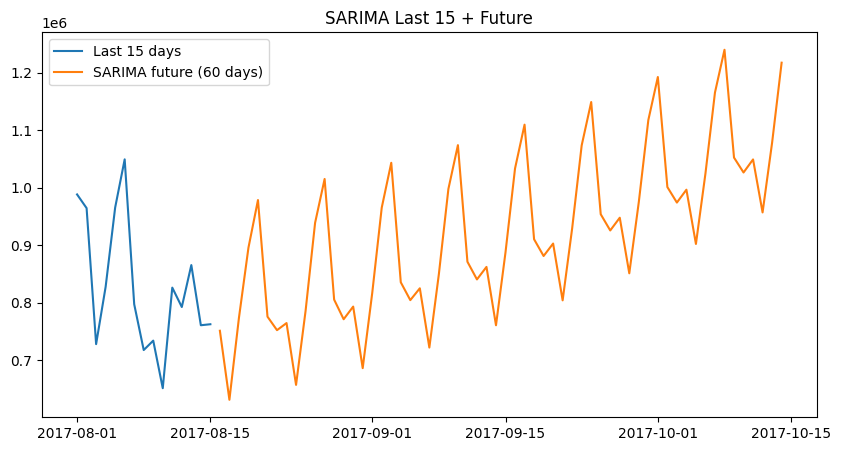

In [71]:
# Cell D: plot residuals on validation and last-15+60 futures for each model if they exist
import matplotlib.pyplot as plt

def plot_val_and_future(model_name, forecast_val_var, future_var):
    if forecast_val_var not in globals():
        print(f"{model_name} validation forecast missing ({forecast_val_var})")
        return
    yhat_val = globals()[forecast_val_var]
    if not hasattr(yhat_val, 'index') or not yhat_val.index.equals(val.index):
        yhat_val = pd.Series(yhat_val, index=val.index).reindex(val.index).fillna(method='ffill')
    # residuals
    res = val - yhat_val
    plt.figure(figsize=(10,4))
    plt.plot(res.index, res.values)
    plt.axhline(0, color='k', linestyle='--', alpha=0.6)
    plt.title(f"{model_name} residuals on validation")
    plt.show()
    # plot last 15 history + future (60)
    if future_var not in globals():
        print(f"{model_name} future forecast missing ({future_var})")
        return
    future = globals()[future_var]
    last15 = sales[-15:]
    plt.figure(figsize=(10,5))
    plt.plot(last15.index, last15.values, label='Last 15 days')
    plt.plot(future.index, future.values, label=f'{model_name} future ({len(future)} days)')
    plt.title(f"{model_name} Last 15 + Future")
    plt.legend()
    plt.show()

# Call for each model
plot_val_and_future('LightGBM', 'lgb_forecast', 'lgb_future')
plot_val_and_future('ARIMA', 'arima_forecast', 'arima_future')
plot_val_and_future('SARIMA', 'sarima_forecast', 'sarima_future')


In [72]:
# Cell E: check create_features source for shift-before-rolling
import inspect, re
if 'create_features' in globals():
    src = inspect.getsource(create_features)
    print("create_features preview:\n")
    print("\n".join(src.splitlines()[:40]))   # show head
    if re.search(r"\.rolling\(", src) and not re.search(r"shift\(\s*1\s*\)\.rolling\(", src) and not re.search(r"series\.shift\(\d+\)\.rolling\(", src):
        print("\nWARNING: I see rolling(...) used without a preceding shift -> potential leakage.")
    else:
        print("\ncreate_features looks OK re: shift+rolling (or no rolling present).")
else:
    print("create_features function not found in this workspace.")


create_features preview:

def create_features(series: pd.Series) -> pd.DataFrame:
    series = pd.Series(series, index=series.index, name="sales").copy()
    feat = pd.DataFrame({"sales": series})
    # Lags
    feat["lag1"] = series.shift(1)
    feat["lag7"] = series.shift(7)
    # FIX: shift BEFORE rolling to avoid leakage
    feat["rolling_mean7"] = series.shift(1).rolling(7).mean()
    # Calendar
    idx = series.index
    feat["dayofweek"] = idx.dayofweek
    feat["month"] = idx.month
    feat["year"] = idx.year
    return feat

create_features looks OK re: shift+rolling (or no rolling present).


In [2]:
# If needed (Kaggle often preinstalls these):
!pip install -q pmdarima lightgbm


In [33]:
# ==============================
# A. Imports & Data Preparation
# ==============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from datetime import datetime

In [34]:
# Tries Kaggle competition path first; falls back to local CSV with (date,sales).
candidates = [
    "/kaggle/input/store-sales-time-series-forecasting/train.csv",
    "/kaggle/input/store-sales-time-seri*/train.csv",
    "train.csv",                 # expects Kaggle-like schema
    "sales.csv"                  # expects columns: date, sales
]

csv_path = None
for pat in candidates:
    ms = glob.glob(pat)
    if ms:
        csv_path = ms[0]
        break

if csv_path is None:
    raise FileNotFoundError("Put Kaggle train.csv or a sales.csv with columns ['date','sales'] next to the notebook.")

print("Using:", csv_path)
df = pd.read_csv(csv_path, parse_dates=["date"])

# Aggregate to total daily sales (one series)
if "store_nbr" in df.columns or "family" in df.columns:
    sales = df.groupby("date")["sales"].sum().sort_index()
else:
    sales = df.set_index("date")["sales"].sort_index()

# Ensure daily frequency, fill missing with 0
sales = sales.asfreq("D").fillna(0.0)

print(sales.head(), "\nRange:", sales.index.min().date(), "→", sales.index.max().date(), "| n =", len(sales))

# Final series
daily_sales = sales


Using: /kaggle/input/store-sales-time-series-forecasting/train.csv
date
2013-01-01      2511.618999
2013-01-02    496092.417944
2013-01-03    361461.231124
2013-01-04    354459.677093
2013-01-05    477350.121229
Freq: D, Name: sales, dtype: float64 
Range: 2013-01-01 → 2017-08-15 | n = 1688


In [35]:
# ==============================
# B. Train-Test Split
# ==============================
# Last 90 days = test, rest = train
train = daily_sales.iloc[:-90]
test  = daily_sales.iloc[-90:]

print("Train size:", len(train), "Test size:", len(test))

Train size: 1598 Test size: 90


In [36]:
# ==============================
# C. ARIMA Forecast
# ==============================
arima_model = ARIMA(train, order=(5,1,0))
arima_fit = arima_model.fit()
arima_forecast = arima_fit.forecast(steps=60)  # predict last 60 days

In [37]:
# ==============================
# D. SARIMA Forecast
# ==============================
sarima_model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,7))
sarima_fit = sarima_model.fit(disp=False)
sarima_forecast = sarima_fit.forecast(steps=60)  # predict last 60 days

In [38]:
# ==============================
# E. LightGBM Forecast
# ==============================
# Prepare features
df_lgb = daily_sales.reset_index()
df_lgb["day"] = df_lgb["date"].dt.day
df_lgb["month"] = df_lgb["date"].dt.month
df_lgb["year"] = df_lgb["date"].dt.year
df_lgb["dayofweek"] = df_lgb["date"].dt.dayofweek

# Train/test split again with features
train_lgb = df_lgb.iloc[:-90]
test_lgb  = df_lgb.iloc[-90:]

X_train = train_lgb[["day","month","year","dayofweek"]]
y_train = train_lgb["sales"]

X_test = test_lgb[["day","month","year","dayofweek"]]
y_test = test_lgb["sales"]

# Train model
lgb_model = lgb.LGBMRegressor()
lgb_model.fit(X_train, y_train)

# Forecast
y_pred_lgb = lgb_model.predict(X_test)

In [39]:
# ==============================
# F. Model Evaluation (RMSE, MAE, MAPE)
# ==============================
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / np.where(y_true == 0, 1e-10, y_true))) * 100

results = {}

# Align test with forecast (last 60 days)
test_eval = test.iloc[-60:]

# ARIMA
rmse_arima = np.sqrt(mean_squared_error(test_eval, arima_forecast))
mae_arima  = mean_absolute_error(test_eval, arima_forecast)
mape_arima = mean_absolute_percentage_error(test_eval, arima_forecast)
results["ARIMA"] = {"RMSE": rmse_arima, "MAE": mae_arima, "MAPE (%)": mape_arima}

# SARIMA
rmse_sarima = np.sqrt(mean_squared_error(test_eval, sarima_forecast))
mae_sarima  = mean_absolute_error(test_eval, sarima_forecast)
mape_sarima = mean_absolute_percentage_error(test_eval, sarima_forecast)
results["SARIMA"] = {"RMSE": rmse_sarima, "MAE": mae_sarima, "MAPE (%)": mape_sarima}

# LightGBM
rmse_lgb = np.sqrt(mean_squared_error(test_eval, y_pred_lgb[-60:]))
mae_lgb  = mean_absolute_error(test_eval, y_pred_lgb[-60:])
mape_lgb = mean_absolute_percentage_error(test_eval, y_pred_lgb[-60:])
results["LightGBM"] = {"RMSE": rmse_lgb, "MAE": mae_lgb, "MAPE (%)": mape_lgb}

# Display neatly
results_df = pd.DataFrame(results).T
print("Model Performance (last 60 days):")
print(results_df.round(2))

Model Performance (last 60 days):
               RMSE        MAE  MAPE (%)
ARIMA     152523.21  126654.52     14.99
SARIMA    227081.28  192265.51     22.49
LightGBM   73680.78   60628.13      6.92


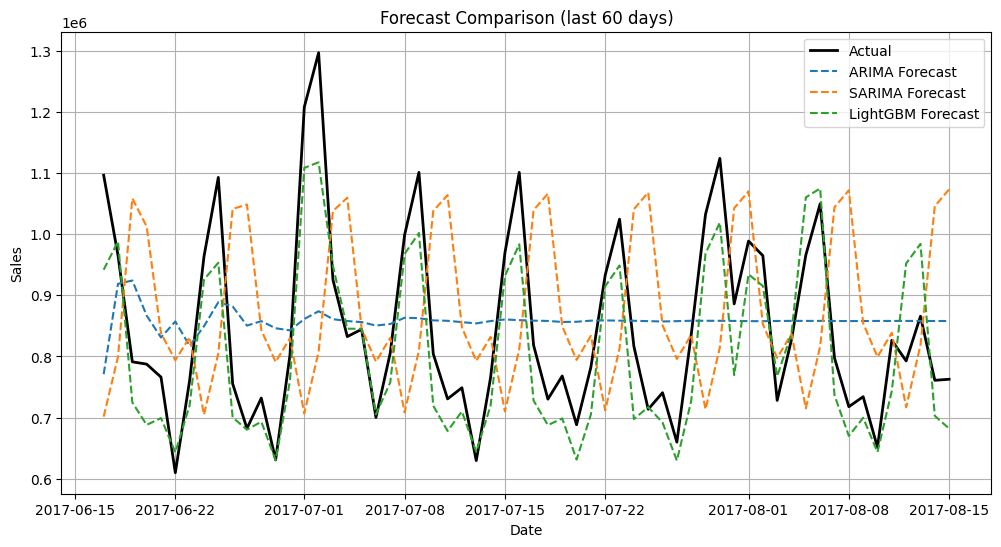

In [40]:
# ==============================
# G. Plot Actual vs Forecasts
# ==============================
plt.figure(figsize=(12,6))

# Actual
plt.plot(test_eval.index, test_eval.values, label="Actual", color="black", linewidth=2)

# Forecasts
plt.plot(test_eval.index, arima_forecast, label="ARIMA Forecast", linestyle="--")
plt.plot(test_eval.index, sarima_forecast, label="SARIMA Forecast", linestyle="--")
plt.plot(test_eval.index, y_pred_lgb[-60:], label="LightGBM Forecast", linestyle="--")

plt.title("Forecast Comparison (last 60 days)")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.show()